In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from table_reader import TableReader
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In order to connect to our database, follow the steps below. Let Seth (seth@sethpeterson.net) know if you need the database connection url. 

    1. Create a file called config.json in the project root.
    2. Inside, config.json should look like this:
    {
        "database_url":"database_url_goes_here"
    }

TableReader's other vector methods are geodata_vector() and reviews_vector(). 

Read in data

In [2]:
tr = TableReader()
prop = tr.properties_vector(include_amenitites=True)
geo = tr.geodata_vector()
ratings = tr.reviews_vector()[['listingID','num_reviews', 'rating']]
tr.close() #Be sure to call close() when you're done so it terminates the connection to the DB.

Merge data frames 

In [3]:
#merge our properties, geo, and rating df on listingID
df = pd.merge(geo, prop, on='listingID')
df = pd.merge(df, ratings, on='listingID', how='left')

In [4]:
df = df[df['num_reviews'] > 10]
df.dropna(subset=['zipcode'], inplace=True)
df.dropna(axis = 0, how ='any', inplace=True) 

In [5]:
df.head()

,listingID,zipcode,latitude,longitude,"Brightwood Park, Crestwood, Petworth","Brookland, Brentwood, Langdon","Capitol Hill, Lincoln Park","Capitol View, Marshall Heights, Benning Heights","Cathedral Heights, McLean Gardens, Glover Park","Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace",...,Keypad,Pets live on this property,Shampoo,Indoor fireplace,Suitable for events,Bed linens,Oven,Bathtub,num_reviews,rating
1,3344,20005.0,38.90126,-77.02857,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,11,100.0
2,3662,20020.0,38.86193,-76.98963,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,36,94.0
3,3686,20020.0,38.86314,-76.98836,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,69,91.0
5,4197,20003.0,38.88791,-76.99668,0,0,1,0,0,0,...,0,1,1,1,0,0,0,0,39,97.0
6,4529,20019.0,38.90645,-76.94305,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,99,93.0


In [6]:
features = df[df.columns.drop(['price', 'listingID'])]
label = df['price']

## Feature Selection

In [7]:
model = ElasticNet()
esfm = SelectFromModel(model)
esfm.fit(features, label)
print(list(features.iloc[:, esfm.get_support(indices=True)]))

['Capitol Hill, Lincoln Park', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Georgetown, Burleith/Hillandale', 'accomodates', 'bathrooms', 'bedrooms', 'beds', 'Guest suite', 'Entire home/apt', 'Private room', 'Shared room', 'Dryer', 'Washer', 'Paid parking off premises', 'TV', 'Free parking on premises', 'Cable TV', 'Gym', 'Self check-in', 'Family/kid friendly', '24-hour check-in', 'First aid kit', 'Internet', 'Free street parking', 'Lock on bedroom door', 'Elevator', 'Indoor fireplace', 'rating']


In [8]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, label)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['zipcode', 'Capitol Hill, Lincoln Park', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Georgetown, Burleith/Hillandale', 'accomodates', 'bathrooms', 'bedrooms', 'Entire home/apt', 'Dryer', 'Free parking on premises', 'Cable TV', 'Gym', 'Family/kid friendly', '24-hour check-in', 'Internet', 'Free street parking', 'Lock on bedroom door', 'Elevator', 'Indoor fireplace', 'num_reviews', 'rating']


In [9]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, label)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['latitude', 'longitude', 'Capitol Hill, Lincoln Park', 'Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace', 'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Edgewood, Bloomingdale, Truxton Circle, Eckington', 'Georgetown, Burleith/Hillandale', 'Howard University, Le Droit Park, Cardozo/Shaw', 'Ivy City, Arboretum, Trinidad, Carver Langston', 'Kalorama Heights, Adams Morgan, Lanier Heights', 'Near Southeast, Navy Yard', 'North Cleveland Park, Forest Hills, Van Ness', 'Shaw, Logan Circle', 'Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point', 'Union Station, Stanton Park, Kingman Park', 'West End, Foggy Bottom, GWU', 'bathrooms', 'bedrooms', 'Apartment', 'Guest suite', 'Serviced apartment', 'Entire home/apt', 'Shared room']


In [10]:
elastic_data = df[list(features.iloc[:, esfm.get_support(indices=True)])]

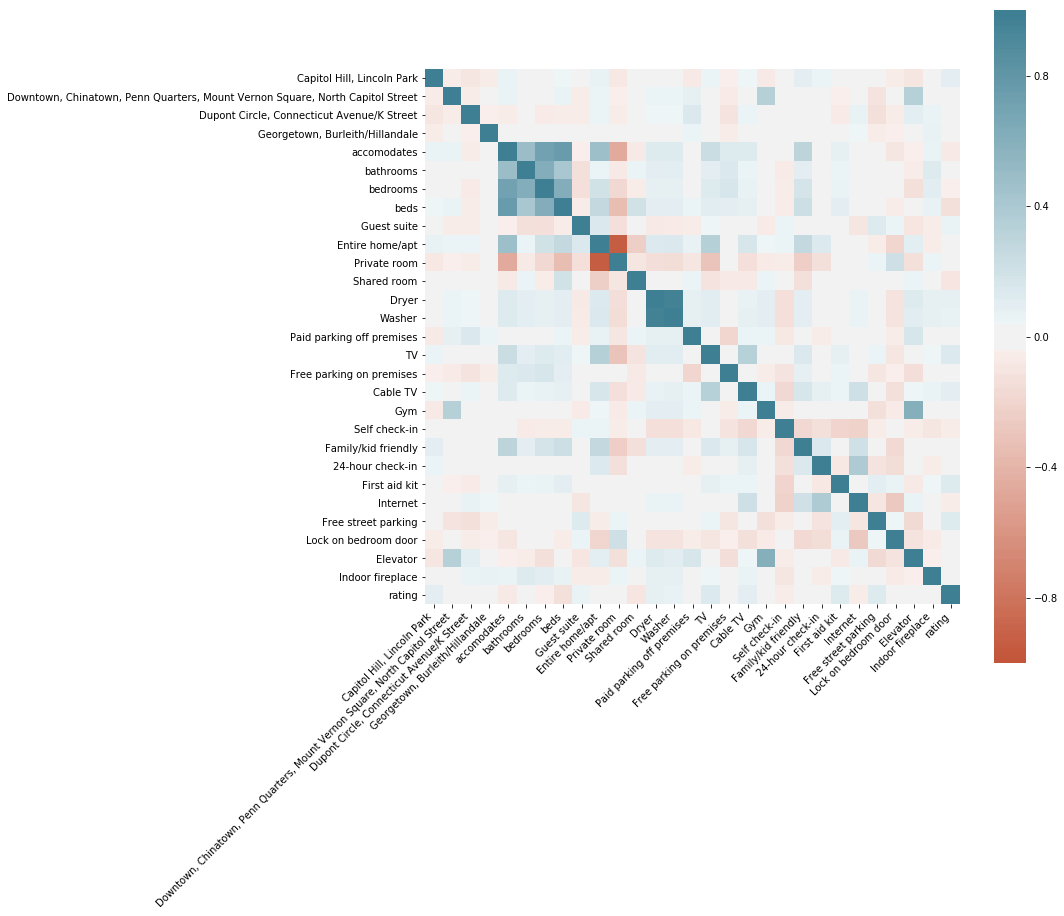

In [11]:
corr = elastic_data.corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.savefig('feature_correlation_heatmap.png', dpi=100)

Chi-squared (chi²) statistical test for non-negative features to select 20 of the best features

In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#drop geo data in the feature selection because Chi2 only works for non-negative features
featureswithoutgeo = features[features.columns.drop(['longitude'])]

#apply SelectKBest class to extract top 20 best features
bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(featureswithoutgeo,label)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(featureswithoutgeo.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 20 best features

                                                 Specs         Score
104                                        num_reviews  27183.566869
30                                         accomodates   2473.582634
42                                         Shared room   2128.129306
33                                                beds   1618.942310
41                                        Private room   1342.079583
38                                  Serviced apartment   1282.085411
32                                            bedrooms   1052.020329
10   Downtown, Chinatown, Penn Quarters, Mount Vern...    827.206153
5      Capitol View, Marshall Heights, Benning Heights    771.429540
57                                                Pool    671.943591
71                                                 Gym    660.933201
40                                     Entire home/apt    650.559290
28                         West End, Foggy Bottom, GWU    630.330009
69                               W

Feature Importance

Feature importance is an inbuilt class that comes with Tree Based Regressor, we will be using Extra Tree Regressor for extracting the top 20 features for the dataset.

[1.18560438e-02 2.12611085e-02 2.34694481e-02 2.12265135e-03
 6.14913503e-04 1.06266736e-02 4.08988772e-04 2.38651151e-03
 1.37526869e-03 2.64256389e-03 4.46323533e-04 8.58930867e-03
 8.12752765e-03 4.59565271e-03 5.81108015e-04 1.25259545e-02
 4.63992287e-03 1.67989343e-03 4.26607664e-03 9.54958161e-04
 3.53477076e-04 4.52575159e-04 1.86373092e-04 7.71329803e-03
 3.08848511e-03 4.55976150e-04 1.78501876e-03 9.28288232e-04
 5.06967523e-03 5.64402876e-03 1.62994755e-03 9.17253318e-02
 1.52169383e-01 1.15743697e-01 2.01640364e-02 7.71267696e-03
 3.65342267e-03 7.36682744e-03 4.14806869e-03 1.28298714e-02
 5.84700755e-03 1.56198902e-01 3.09283092e-03 2.67737891e-03
 5.15108157e-03 2.83432587e-03 3.90657590e-03 1.46413472e-04
 4.28784169e-03 3.57027911e-03 6.07929935e-04 1.54270390e-03
 3.90557421e-03 5.61692676e-03 5.24004395e-03 7.57984779e-03
 4.69989617e-04 3.00749945e-04 4.08196994e-03 2.94319213e-03
 5.00950730e-03 4.05560038e-03 6.07259272e-03 7.20227559e-03
 1.37460540e-03 5.439069

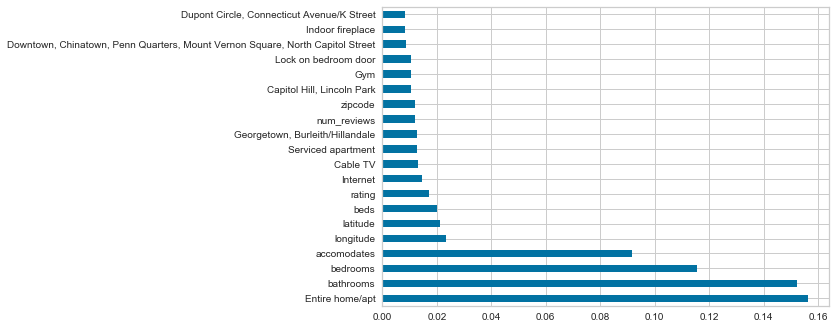

Entire home/apt                                                                  0.156199
bathrooms                                                                        0.152169
bedrooms                                                                         0.115744
accomodates                                                                      0.091725
longitude                                                                        0.023469
latitude                                                                         0.021261
beds                                                                             0.020164
rating                                                                           0.017017
Internet                                                                         0.014637
Cable TV                                                                         0.013177
Serviced apartment                                                               0.012830
Georgetown

In [44]:
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt

model = ExtraTreesRegressor()
model.fit(features,label)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=features.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

## Model Evaluation with top 20 features

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [50]:
Top20Features = [
    'latitude',
    'num_reviews',
    'longitude',
    'rating',
    'accomodates',
    'zipcode',
    'beds',
    'Entire home/apt',
    'bedrooms',
    'Internet',
    'Lock on bedroom door',
    'bathrooms',                   
    'Fire extinguisher',          
    'Laptop friendly workspace',    
    'Hair dryer',         
    'Cable TV',
    'Capitol Hill, Lincoln Park',                                           
    'Gym',                                                          
    'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street',
    'Indoor fireplace',                                                      
    'Dupont Circle, Connecticut Avenue/K Street',
    'Georgetown, Burleith/Hillandale',
]

X_train_featureSelection, X_test_featureSelection, y_train_featureSelection, y_test_featureSelection = tts(features[Top20Features], label, test_size=0.2)

regr = LinearRegression()
regr.fit(X_train_featureSelection,y_train_featureSelection)
print(mean_squared_error(y_test_featureSelection, regr.predict(X_test_featureSelection)))
print(regr.score(X_test_featureSelection,y_test_featureSelection))

1830.902031802436
0.6161644626489866


## Remove features with high correlations
Quick Model Comparison Between Models with highly correlated features vs without

In [16]:
featuresWithoutHighCorrFeature = features[features.columns.drop(['beds', 'Private room','Elevator','Dryer'])]

In [17]:
#Split without highly correlated features
X_train_featureSelection, X_test_featureSelection, y_train_featureSelection, y_test_featureSelection = tts(featuresWithoutHighCorrFeature, label, test_size=0.2)
#Split with all features
X_train, X_test, y_train, y_test = tts(features, label, test_size=0.2)

In [18]:
regr = LinearRegression()
regr.fit(X_train_featureSelection,y_train_featureSelection)
print('The mean squared error for model without highly correlated feature: ' + str(mean_squared_error(y_test_featureSelection, regr.predict(X_test_featureSelection))))
print('The r2 for model without highly correlated feature: ' + str(regr.score(X_test_featureSelection, y_test_featureSelection)))

regr = LinearRegression()
regr.fit(X_train,y_train)
print('The mean squared error for model with all features: ' + str(mean_squared_error(y_test, regr.predict(X_test))))
print('The r2 for model with all featuers: '+ str(regr.score(X_test,y_test)))

The mean squared error for model without highly correlated feature: 1779.3391343668065
The r2 for model without highly correlated feature: 0.6201700888629048
The mean squared error for model with all features: 1639.9780620534555
The r2 for model with all featuers: 0.6279786921337805


# Model Selection

The following models are from Georgetown Data Analytics (CCPE), under the machine learning notebook: https://github.com/georgetown-analytics/machine-learning/tree/master/notebook

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = tts(featuresWithoutHighCorrFeature, label, test_size=0.2)

Linear Regression

In [20]:
lr = LinearRegression()
lr.fit(X_train,y_train)
print(mean_squared_error(y_test, lr.predict(X_test)))
print(lr.score(X_test,y_test))

1846.0704504555888
0.6342625254072086


Lasso

In [21]:
lasso_model = Lasso()
lasso_model.fit(X_train,y_train)
print('Lasso mean squared error: ' + str(mean_squared_error(y_test, lasso_model.predict(X_test))))
print('Lasso R^2: '+ str(lasso_model.score(X_test, y_test)))

Lasso mean squared error: 2345.0215340923355
Lasso R^2: 0.5354119592061164


Ridge

In [22]:
ridge_model = Ridge()
ridge_model.fit(X_train,y_train)
print('Ridge mean squared error: '+ str(mean_squared_error(y_test, ridge_model.predict(X_test))))
print('Ridge R^2: '+ str(ridge_model.score(X_test, y_test)))

Ridge mean squared error: 1866.4717988859486
Ridge R^2: 0.630220676597286


# Hyperparameter tuning

Ridge

In [23]:
import numpy as np

# try 200 different alphas between -10 and -2
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

model_ridge = RidgeCV(alphas=alphas)
model_ridge.fit(X_train, y_train)

#which alpha did it pick?
print(model_ridge.alpha_)


0.01


In [24]:
ridge_a = Ridge(alpha=0.01)
ridge_a.fit(X_train, y_train)
print('Ridge mean squared error: '+ str(mean_squared_error(y_test, ridge_a.predict(X_test))))
print('Ridge R^2: '+ str(ridge_a.score(X_test, y_test)))

Ridge mean squared error: 1846.262938783433
Ridge R^2: 0.6342243902456297


Lasso

In [25]:
from sklearn.model_selection import GridSearchCV

lasso = Lasso(random_state=0)

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_params = [{'alpha': alphas}]
n_folds = 12

grid = GridSearchCV(
    lasso, tuned_params, cv=n_folds
)

grid.fit(X_train, y_train)
print(grid.best_estimator_)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False)


In [26]:
lasso_a = Lasso(alpha=0.01)
lasso_a.fit(X_train, y_train)
print('Lasso mean squared error: ' + str(mean_squared_error(y_test, lasso_a.predict(X_test))))
print('Lasso R^2: '+ str(lasso_a.score(X_test, y_test)))

Lasso mean squared error: 1852.4796096779228
Lasso R^2: 0.6329927636233823


# Model Evaluation

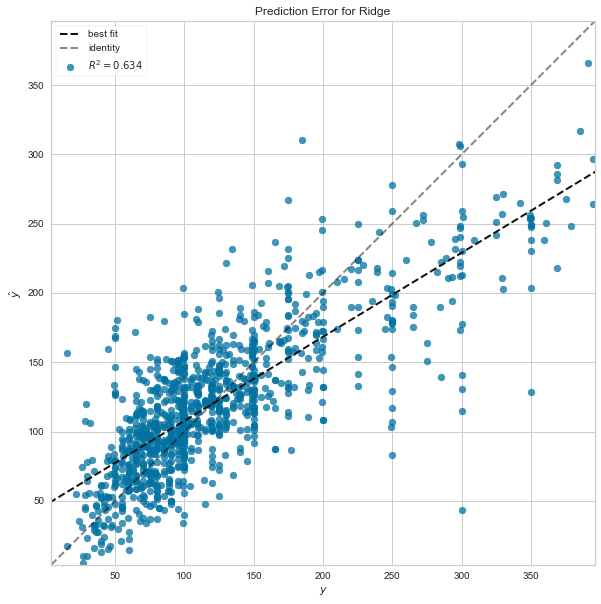

In [27]:
from yellowbrick.regressor import PredictionError

model_r = Ridge(alpha=0.01)
visualizer = PredictionError(model_r, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

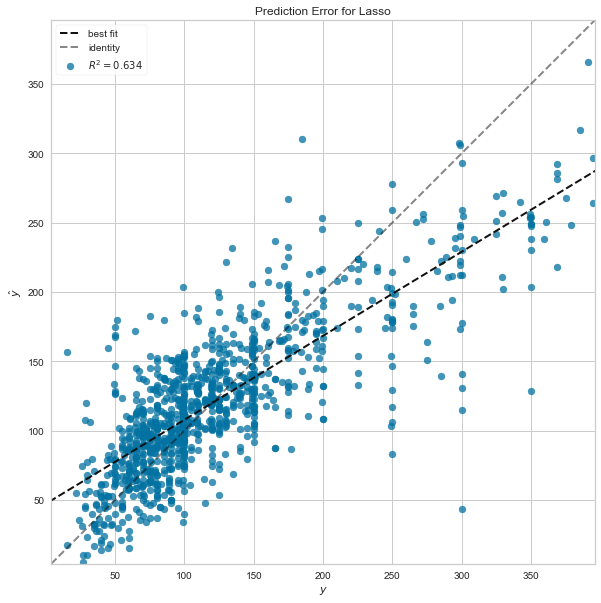

In [28]:
model_l = Lasso(alpha=0.001)
visualizer = PredictionError(model_l, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Mean cv score: 0.6193758428210021


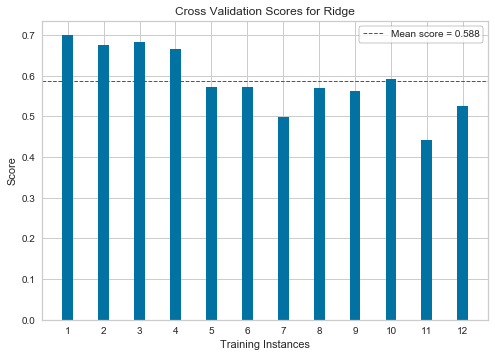

In [29]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores
from statistics import mean
from sklearn.model_selection import cross_val_score

scores = cross_val_score(ridge_a, featuresWithoutHighCorrFeature, label, cv=12)          

print('Mean cv score: '+ str(mean(scores)))

cv = StratifiedKFold(n_splits=12, random_state=42)
visualizer_ridge = CVScores(ridge_a, cv=cv, scoring='r2')

visualizer_ridge.fit(featuresWithoutHighCorrFeature.values, label.values)        # Fit the data to the visualizer
visualizer_ridge.poof()           # Draw/show/poof the data

Mean cv score: 0.6191795125447884


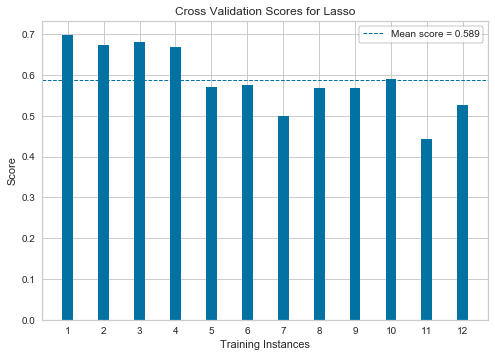

In [30]:
scores = cross_val_score(lasso_a, featuresWithoutHighCorrFeature, label, cv=12)          

print('Mean cv score: '+ str(mean(scores)))

cv = StratifiedKFold(n_splits=12, random_state=42)
visualizer_lasso = CVScores(lasso_a, cv=cv, scoring='r2')

visualizer_lasso.fit(featuresWithoutHighCorrFeature.values, label.values)        # Fit the data to the visualizer
visualizer_lasso.poof()           # Draw/show/poof the data

Mean cv score: 0.619349902688628


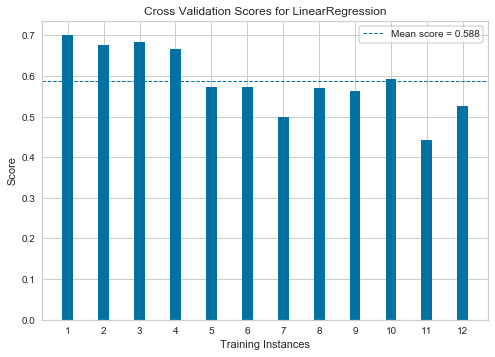

In [31]:
scores = cross_val_score(lr, featuresWithoutHighCorrFeature, label, cv=12)          

print('Mean cv score: '+ str(mean(scores)))

cv = StratifiedKFold(n_splits=12, random_state=42)
visualizer_lr = CVScores(lr, cv=cv, scoring='r2')

visualizer_lr.fit(featuresWithoutHighCorrFeature.values, label.values)        # Fit the data to the visualizer
visualizer_lr.poof()           # Draw/show/poof the data

In [32]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

def func(x): return np.log(x)
def inverse_func(x): return np.exp(x)

featuresWithoutHighCorrFeature = features[features.columns.drop(['bedrooms', 'beds', 'Private room','Elevator','Dryer','latitude','longitude'])]

transformer = QuantileTransformer(output_distribution='normal')
regressor = LinearRegression()
regr = TransformedTargetRegressor(regressor=regressor, func=func,inverse_func=inverse_func)
X_train, X_test, y_train, y_test = tts(featuresWithoutHighCorrFeature, label, test_size=0.2)

X_train.describe()

,zipcode,"Brightwood Park, Crestwood, Petworth","Brookland, Brentwood, Langdon","Capitol Hill, Lincoln Park","Capitol View, Marshall Heights, Benning Heights","Cathedral Heights, McLean Gardens, Glover Park","Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace","Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View","Congress Heights, Bellevue, Washington Highlands","Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street",...,Keypad,Pets live on this property,Shampoo,Indoor fireplace,Suitable for events,Bed linens,Oven,Bathtub,num_reviews,rating
count,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,...,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000
mean,20010.725236,0.052123,0.020283,0.094575,0.007783,0.011557,0.012028,0.099292,0.008491,0.033962,...,0.050236,0.095519,0.823821,0.128066,0.031840,0.037028,0.007075,0.013443,67.035613,95.453538
std,58.272114,0.222301,0.140983,0.292662,0.087888,0.106891,0.109025,0.299090,0.091763,0.181153,...,0.218457,0.293965,0.381018,0.334203,0.175594,0.188853,0.083828,0.115177,69.512653,3.819990
min,20001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,85.000000
25%,20002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,94.000000
50%,20007.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,96.000000
75%,20011.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,86.250000,98.000000
max,22209.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,728.000000,100.000000


In [33]:
regr.fit(X_train, y_train) 
TransformedTargetRegressor(...)

print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

raw_target_regr = LinearRegression().fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(raw_target_regr.score(X_test, y_test)))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').